# **Clone the PyTorch I3D model**
https://github.com/piergiaj/pytorch-i3d.git

In [1]:
# ! git clone https://github.com/piergiaj/pytorch-i3d.git

In [2]:
! pwd

/home/pjsimmon/ECE285_Final_Dataset/drive-pytorch-i3d


In [3]:
new_kinect_ir_train_list = "kinect_ir_processed_list_rgb_split0train.txt"

# **Test Functionality of PyTorch I3D model**

### Starting with charades_dataset.py:


In [4]:
import torch
import torch.utils.data as data_utl
from torch.utils.data.dataloader import default_collate

import numpy as np
import json
import csv
import h5py
import random
import os
import os.path

import cv2

In [163]:
# Testing getting a tensor from one of our .npy files:
def video_to_tensor(pic):
    """Convert a ``numpy.ndarray`` to tensor.
    Converts a numpy.ndarray (T x H x W x C)
    to a torch.FloatTensor of shape (C x T x H x W)
    
    Args:
         pic (numpy.ndarray): Video to be converted to tensor.
    Returns:
         Tensor: Converted video.
    """
    #return torch.from_numpy(pic.transpose([3,0,1,2]))
    return torch.from_numpy(pic.transpose([0, 4, 1, 2, 3]))



## Updated with new path to kinect_ir .npy files 

In [7]:
# Old path to .npy files
root = "../../ece285_sp20_team01/kinect_ir/output/"
path_to_npy_files = root + "video_npy/"
path_to_train_list = root + new_kinect_ir_train_list
path_to_test_npy = "../../ece285_sp20_team01/kinect_ir/output/video_npy/run1_2018-05-03-14-08-31.kinect_ir.mp4_000500_000557.npy"

print(os.path.exists(path_to_npy_files))
print(os.path.exists(path_to_train_list))
print(os.path.exists(path_to_test_npy))


True
True
True


In [9]:
test_npy = np.load(path_to_test_npy)
print(test_npy.shape)

(1, 58, 224, 224, 1)


## Adapt make_dataset and charades_dataset to our dataset, Drive&Act:

In [36]:
# Adaptation of make_dataset to use out train_list rather than a .json file: 

# Replace charades_dataset.py with this: 
def make_our_dataset(train_list):
    dataset = []
    with open(train_list, 'r') as f: 
        Lines = f.readlines()
        for line in Lines: 
            line = line.strip()
            if (len(line) > 0):
                contents = line.split(" ")
                
                vid_path = contents[0]
                activity = contents[1]
                
                # get number of frames from name of vid_path
                # (using new ir list): 

                start_str = ".mp4_"
                end_str = " "

                num_frames = (vid_path.split(start_str))[1].split(end_str)[0]
                start_frame = int(num_frames.split("_")[0])
                end_frame = int(num_frames.split("_")[1])                

                num_frames = end_frame - start_frame
                
                
                if int(num_frames) < 64: 
                    continue
                    
                dataset.append((vid_path, activity, num_frames))

    return dataset

In [37]:
train_data = make_our_dataset(path_to_train_list)
print(len(train_data))

for row in train_data[0:5]:
    print(row)

5144
('video_npy/run1b_2018-05-29-14-02-47.kinect_ir.mp4_000348_000439', '9', 91)
('video_npy/run1b_2018-05-29-14-02-47.kinect_ir.mp4_000461_000531', '10', 70)
('video_npy/run1b_2018-05-29-14-02-47.kinect_ir.mp4_006021_006111', '8', 90)
('video_npy/run1b_2018-05-29-14-02-47.kinect_ir.mp4_006111_006202', '0', 91)
('video_npy/run1b_2018-05-29-14-02-47.kinect_ir.mp4_006229_006311', '10', 82)


## Helper function to balance the training class samples:

In [38]:
def sample_data(train_data):

    len_data = len(train_data)
    num_labels = 39

    sample_labels = np.zeros(num_labels)

    for row in train_data: 
        label = row[1]
        sample_labels[int(label)] += 1

    return sample_labels

In [39]:
# Need to make sure each activity appears at least once in the training set: 

train_sampled_data = sample_data(train_data)
#val_sampled_data = sample_data(val_data)

print(train_sampled_data)
#print(train_sampled_data + val_sampled_data)

[1627.    0.   14.    0.    0.   20.    9.  327.   17.   91.   51.   14.
  270.  291.   90.   46.  450.   27.    0.  410.  194.   54.   43.  123.
   17.    3.  174.  283.   36.   26.   12.    9.  296.   73.   31.   16.
    0.    0.    0.]


In [59]:
# Need to create a *representative* training set.
import random

all_data = train_data
num_classes = 39
data_dict = {}

train_data_sample = []
val_data_sample = []
test_data_sample = []

for i in range(num_classes):
    data_dict[i] = 0

# the train/val/test split will be 65/25/10
for row in all_data: 
    activity = int(row[1])
    if data_dict[activity] < 0.65*train_sampled_data[activity]:
        train_data_sample.append(row)
        data_dict[activity] += 1
    else: 
        prob = random.random()
        if prob < float(25/35): 
            #random 25/35 chance of going into validation: 
            val_data_sample.append(row)
        else:
            #random 10/35 chance of going into test:
            test_data_sample.append(row)

print(len(train_data_sample))
print(len(val_data_sample))
print(len(test_data_sample))

#print(train_data_sample)

train_list_sampled_data = sample_data(train_data_sample)
val_list_sampled_data = sample_data(val_data_sample)
test_list_sampled_data = sample_data(test_data_sample)

print(train_list_sampled_data)
print(val_list_sampled_data)
print(test_list_sampled_data)

3360
1286
498
[1058.    0.   10.    0.    0.   13.    6.  213.   12.   60.   34.   10.
  176.  190.   59.   30.  293.   18.    0.  267.  127.   36.   28.   80.
   12.    2.  114.  184.   24.   17.    8.    6.  193.   48.   21.   11.
    0.    0.    0.]
[402.   0.   4.   0.   0.   5.   2.  84.   1.  18.  11.   2.  63.  76.
  25.   9. 117.   5.   0. 105.  52.  14.   9.  28.   5.   1.  47.  72.
   8.   4.   4.   3.  86.  14.   6.   4.   0.   0.   0.]
[167.   0.   0.   0.   0.   2.   1.  30.   4.  13.   6.   2.  31.  25.
   6.   7.  40.   4.   0.  38.  15.   4.   6.  15.   0.   0.  13.  27.
   4.   5.   0.   0.  17.  11.   4.   1.   0.   0.   0.]


In [65]:
# Create a train, val, test list from each of the sampled datas: 

'''
def write_data_to_list(filename, data_list):
    with open(filename, 'w') as f: 
        for row in data_list: 
            f.write(row[0] + " " + row[1])
            f.write("\n")
    
    
write_data_to_list("new_kinect_ir_train.txt", train_data_sample)
write_data_to_list("new_kinect_ir_val.txt", val_data_sample)
write_data_to_list("new_kinect_ir_test.txt", test_data_sample)
'''

In [80]:
# Sample code to create the WeightedRandomSampler
import torch
from torch.utils.data.sampler import Sampler

numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))

print(class_sample_count)
print(weight)
print(samples_weight)

[900 100]
[0.00111111 0.01      ]
tensor([0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
      

In [94]:
# Logic: we will upsample the small classes and downsample the large classes.
# The classes that are 0 we never see in our train or test sets.

# Link to sampler code: https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/2

def training_sampler(train_list):
    train_sampled_data = sample_data(train_list)
    train_weight = []
    
    for v in train_sampled_data: 
        if v == 0: 
            train_weight.append(0)
        else:
            train_weight.append(1. / v)

    # Create the weight samples for the WeightedRanomSampler
    samples_weight = []
    for row in train_list: 
        activity = int(row[1])
        samples_weight.append(train_weight[activity])
        
    samples_weight = torch.from_numpy(np.array(samples_weight))
    samples_weight = samples_weight.double()
    sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))
    
    return train_weight, samples_weight, sampler

In [100]:
train_weights, train_samples_weights, train_sampler = training_sampler(train_data_sample)
print(train_weights)
print()
print(len(train_samples_weights), len(train_data_sample))
print(train_samples_weights)
print()
print(train_sampler)

[0.000945179584120983, 0, 0.1, 0, 0, 0.07692307692307693, 0.16666666666666666, 0.004694835680751174, 0.08333333333333333, 0.016666666666666666, 0.029411764705882353, 0.1, 0.005681818181818182, 0.005263157894736842, 0.01694915254237288, 0.03333333333333333, 0.0034129692832764505, 0.05555555555555555, 0, 0.003745318352059925, 0.007874015748031496, 0.027777777777777776, 0.03571428571428571, 0.0125, 0.08333333333333333, 0.5, 0.008771929824561403, 0.005434782608695652, 0.041666666666666664, 0.058823529411764705, 0.125, 0.16666666666666666, 0.0051813471502590676, 0.020833333333333332, 0.047619047619047616, 0.09090909090909091, 0, 0, 0]

3360 3360
tensor([0.0167, 0.0294, 0.0833,  ..., 0.1000, 0.1000, 0.1000],
       dtype=torch.float64)



In [13]:
# Randomly select 64 frames from the passed in npy file. 

def random64frames(npy_file):
    img_array = np.load(npy_file)
    
    print("shape: ", img_array.shape)
    
    num_frames = img_array.shape[0] / 224.0 
    if mode == 'ir':
        num_channels = 1
    
    img_array = img_array.reshape(int(num_frames), 224, 224, 1)
    print(img_array.shape)
    
    choices = num_frames - 64
    
    rand_start = random.randint(0, choices)
    print(rand_start)
    img_array = img_array[rand_start:rand_start+64, :, :, :]
    
    return img_array

In [170]:
class DriveAndAct(data_utl.Dataset):

    def __init__(self, train_list, mode, root, transforms=None):
        
        self.data = make_our_dataset(train_list)
        self.mode = mode # FLOW, RGB, gray
        self.root = root # root_dir that points to mode .npy files
        self.transforms = transforms # which transforms to perform 

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        vid, label, nf = self.data[index]

        # imgs should be a .npy array with the correct dimensions
        if self.mode == 'rgb':
            # TO DO: change to rgb dir
            print("TO DO: change to rgb dir")
            # gray_path = "data/drive_and_act_dataset/simmons_kinect_ir_train/"
            # imgs = np.load(gray_path + self.data[index][0])
            channels = 3
        elif self.mode == 'flow':
            # TO DO: change to flow dir
            print("TO DO: change to flow dir")
            # gray_path = "data/drive_and_act_dataset/simmons_kinect_ir_train/"
            # imgs = np.load(gray_path + self.data[index][0])
            channels = 2
        elif self.mode == 'ir': 
            # new list: 
            gray_path = "../../ece285_sp20_team01/kinect_ir/output/"
            imgs = np.load(gray_path + self.data[index][0] + '.npy')
            imgs = imgs.astype(np.float32)
            imgs = (imgs/255.)*2-1 # normalization
            channels = 1
        elif self.mode == 'depth': 
            gray_path = "/home/yuj010/ECE285/output/"
            imgs = np.load(gray_path + self.data[index][0] + '.npy')
            imgs = imgs.astype(np.float32)
            imgs = (imgs/255.)*2-1 # normalization
            channels = 3
        else: 
            print("did not specify correct mode for data")

        label = self.data[index][1]
        
        # Randomly select 64 frames:
        num_frames = int(imgs.shape[1])
        choices = int(num_frames) - 64
        if choices <= 0: 
            rand_start = 0
        else: 
            rand_start = random.randint(0, choices)
        img_array = imgs[:, rand_start:rand_start+64, :, :, :]
            

        num_classes = 39

        imgs = np.asarray(img_array, dtype='float32' )


        # This is for 'gray' mode: (don't need for FLOW or RGB mode)
        imgs = np.repeat(img_array, 3, axis=4)

        label = int(label)
        labels = np.zeros((num_classes,num_frames), np.float32)
        labels[int(label),:] = 1
        
        return video_to_tensor(imgs), torch.from_numpy(labels)

    def __len__(self):
        return len(self.data)

## **Test functionality of make_our_dataset and DriveAndAct dataset class**


In [19]:
# Create two sample lists: train_list and eval_list: (already done in google drive)
'''
import random
len_ir_dataset = len(drive_data)

original_list = "../drive-pytorch-i3kinect_ir_processed_list_split0train.txt"
with open(original_list, 'r') as f1: 
    with open('../sample_train_list.txt', 'w') as f2: 
        with open('../sample_val_list.txt', 'w') as f3:
            with open('../sample_test_list.txt', 'w') as f4:
                Lines = f1.readlines()
                random.shuffle(Lines)
                for i,line in enumerate(Lines):
                    if i < int(len_ir_dataset * (4 / 5)):
                        f2.write(line) 
                    else:
                        f3.write(line)

!cat ../output/sample_test_list.txt
'''

'\nimport random\nlen_ir_dataset = len(drive_data)\n\noriginal_list = "../drive-pytorch-i3kinect_ir_processed_list_split0train.txt"\nwith open(original_list, \'r\') as f1: \n    with open(\'../sample_train_list.txt\', \'w\') as f2: \n        with open(\'../sample_val_list.txt\', \'w\') as f3:\n            with open(\'../sample_test_list.txt\', \'w\') as f4:\n                Lines = f1.readlines()\n                random.shuffle(Lines)\n                for i,line in enumerate(Lines):\n                    if i < int(len_ir_dataset * (4 / 5)):\n                        f2.write(line) \n                    else:\n                        f3.write(line)\n\n!cat ../output/sample_test_list.txt\n'

In [104]:
train_list = "new_kinect_ir_train.txt"
val_list = "new_kinect_ir_val.txt"
test_list = "new_kinect_ir_test.txt"

print(os.path.exists(train_list))
print(os.path.exists(val_list))
print(os.path.exists(test_list))

True
True
True


In [141]:
# Need to be in pytorch-i3d directory
import os
import sys
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms

import random
import numpy as np

# This is the I3D model used by the Drive&Act paper
from i3dpt import I3D


In [106]:
model_rgb_path = "model_rgb.pth"
model_flow_path = "model_flow.pth"

In [ ]:
# Need to be in pytorch-i3d directory

# Choose a mode: 'ir', 'depth', 'rgb', 'flow'. 

# Change batch size equal to 1. 
def drive_run(init_lr=0.01, max_steps=150, train_loss = [], val_loss = [], mode='ir', root="", batch_size=1, save_model='', weighted_sampler=None):
    
    root_path = ""
    train_list = "new_kinect_ir_train.txt"
    val_list = "new_kinect_ir_val.txt"

    train_transforms = None
    test_transforms = None

    # create a dataset from our DriveAndAct dataset: 
    # !ls
    train_dataset = DriveAndAct(train_list, mode, root=root_path, transforms=None)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, sampler=weighted_sampler)

    val_dataset = DriveAndAct(val_list, mode, root=root_path, transforms=None)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True, sampler=None)

    dataloaders = {'train': train_dataloader, 'val': val_dataloader}
    datasets = {'train': train_dataset, 'val': val_dataset}

    
    # setup the model
    if mode == 'ir':
        i3d = I3D(400, modality = 'rgb')
        i3d.load_state_dict(torch.load('model_rgb.pth'))
    num_classes = 39
    i3d.replace_logits(num_classes)


    i3d.cuda()
    i3d = nn.DataParallel(i3d)

    lr = init_lr
    optimizer = optim.SGD(i3d.parameters(), lr=lr, momentum=0.9, weight_decay=0.0000001)
    lr_sched = optim.lr_scheduler.MultiStepLR(optimizer, [300, 1000])


    num_steps_per_update = 8 # accumulating gradients ("virtual" batch size)
    steps = 0

    # train it
    while steps < max_steps: #for epoch in range(num_epochs):
        print('Step {}/{}'.format(steps, max_steps))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                i3d.train(True)
            else:
                i3d.train(False)  # Set model to evaluate mode
                
            tot_loss = 0.0
            tot_loc_loss = 0.0
            tot_cls_loss = 0.0
            num_iter = 0
            optimizer.zero_grad()
            
            # Iterate over data.
            for data in dataloaders[phase]:
                num_iter += 1
                # get the inputs
                inputs, labels = data
                
                inputs = inputs.reshape(inputs.shape[1], inputs.shape[2], inputs.shape[3], inputs.shape[4], inputs.shape[5])


                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                t = inputs.size(2)
                labels = Variable(labels.cuda())
                out, per_frame_logits = i3d(inputs)
                #print(per_frame_logits.size())
                # upsample to input size
                #per_frame_logits = np.array(per_frame_logits, dtype = 'float')
                #per_frame_logits = torch.from_numpy(per_frame_logits)
                #per_frame_logits = F.upsample(per_frame_logits, t, mode='linear')
                
                # compute localization loss
                #loc_loss = F.binary_cross_entropy_with_logits(per_frame_logits, labels)
                #tot_loc_loss += loc_loss.item()
                loc_loss = 0
                # compute classification loss (with max-pooling along time B x C x T)
                #cls_loss = F.binary_cross_entropy_with_logits(torch.max(per_frame_logits, dim=2)[0], torch.max(labels, dim=2)[0])
                #print(per_frame_logits, labels[:,:,-1])
                cls_loss = F.binary_cross_entropy_with_logits(per_frame_logits, labels[:,:,-1])
                tot_cls_loss += cls_loss.item()

                loss = (cls_loss)/num_steps_per_update
                tot_loss += loss.item()
                loss.backward()



                if num_iter == num_steps_per_update and phase == 'train':
                    steps += 1
                    num_iter = 0

                    # weights don't update until optimizer.step() called
                    optimizer.step()

                    optimizer.zero_grad()
                    lr_sched.step()

                    # make sure model is being saved in case we get kicked off datahub
                    if steps % 10 == 0:
                        print('{} Loc Loss: {:.4f} Cls Loss: {:.4f} Tot Loss: {:.4f}'.format(phase, tot_loc_loss/(10*num_steps_per_update), tot_cls_loss/(10*num_steps_per_update), tot_loss/10))
                        # save model
                        if steps % 20 == 0:
                            torch.save(i3d.module.state_dict(), save_model+str(steps).zfill(6)+'.pt')
                        train_loss.append(tot_loss/10)
                        tot_loss = tot_loc_loss = tot_cls_loss = 0.
                        
                    
                if phase == 'val':
                    print('{} Loc Loss: {:.4f} Cls Loss: {:.4f} Tot Loss: {:.4f}'.format(phase, tot_loc_loss/num_iter, tot_cls_loss/num_iter, (tot_loss*num_steps_per_update)/num_iter))
                    val_loss.append((tot_loss*num_steps_per_update)/num_iter)


if __name__ == '__main__':
    t_loss = []
    v_loss = []
    drive_run(train_loss = t_loss, val_loss = v_loss, weighted_sampler=train_sampler)


Step 0/150
----------
train Loc Loss: 0.0000 Cls Loss: 0.9136 Tot Loss: 0.9136


In [110]:
#print(t_loss)
#print(v_loss)

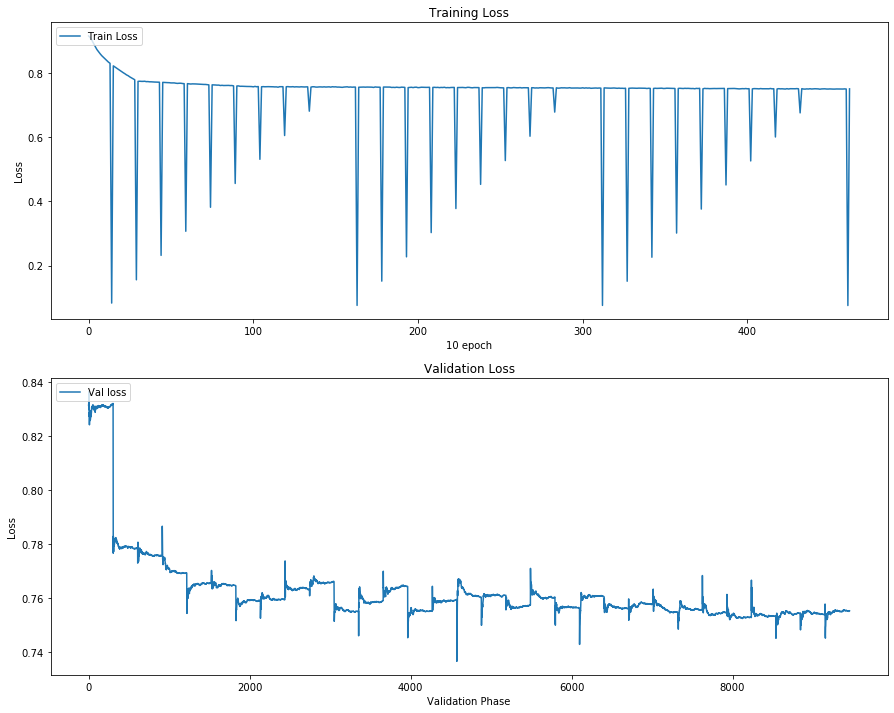

In [227]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,12))
plt.subplot(211)
plt.plot(t_loss)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('10 epoch')
plt.legend(['Train Loss'], loc='upper left')


plt.subplot(212)
plt.plot(v_loss)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Validation Phase')
plt.legend(['Val loss'], loc='upper left')
plt.show()

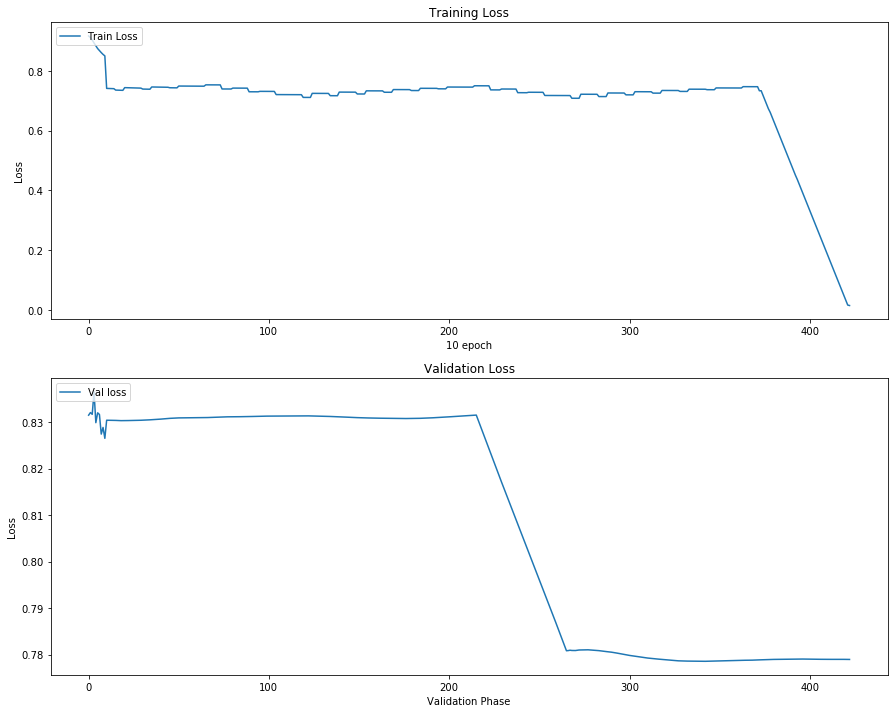

In [242]:
# Smooth out the losses in training and validation: 
window = 50

new_t_loss = []
new_v_loss = []

for i in range(0,10):
    new_t_loss.append(t_loss1[i])
    new_v_loss.append(v_loss1[i])

for i in range(window, len(t_loss1)):
    new_t_loss.append(sum(t_loss1[i:i+window]) / window)
    new_v_loss.append(sum(v_loss1[i:i+window]) / window)
    
    
#print(new_t_loss)

plt.figure(figsize=(15,12))
plt.subplot(211)
plt.plot(new_t_loss)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('10 epoch')
plt.legend(['Train Loss'], loc='upper left')


plt.subplot(212)
plt.plot(new_v_loss)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Validation Phase')
plt.legend(['Val loss'], loc='upper left')
plt.show()

In [243]:
! pwd
! ls

/home/pjsimmon/ECE285_Final_Dataset/drive-pytorch-i3d
i3dpt.py	       saved_models001500.pt  saved_models003100.pt
model_flow.pth	       saved_models001520.pt  saved_models003120.pt
model_rgb.pth	       saved_models001540.pt  saved_models003140.pt
__pycache__	       saved_models001560.pt  saved_models003160.pt
pytorch-i3d	       saved_models001580.pt  saved_models003180.pt
saved_models	       saved_models001600.pt  saved_models003200.pt
saved_models000020.pt  saved_models001620.pt  saved_models003220.pt
saved_models000040.pt  saved_models001640.pt  saved_models003240.pt
saved_models000060.pt  saved_models001660.pt  saved_models003260.pt
saved_models000080.pt  saved_models001680.pt  saved_models003280.pt
saved_models000100.pt  saved_models001700.pt  saved_models003300.pt
saved_models000120.pt  saved_models001720.pt  saved_models003320.pt
saved_models000140.pt  saved_models001740.pt  saved_models003340.pt
saved_models000160.pt  saved_models001760.pt  saved_models003360.pt
saved_models000

In [307]:
from tqdm import tqdm
def test(mode='ir', batch_size=1, accuracy_per_frame = False):
    correct = 0
    total = 0
    
    test_transforms=None
    
    root_path = ""
    train_list = "../original-pytorch-i3d/kinect_ir_train0.txt"
    val_list= "../original-pytorch-i3d/kinect_ir_val0.txt"
    test_list = "../original-pytorch-i3d/kinect_ir_test0.txt"
    val_list = train_list

    train_dataset = DriveAndAct(train_list, mode=mode, root='', transforms=test_transforms)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
    
    val_dataset = DriveAndAct(val_list, mode=mode, root='', transforms=test_transforms)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)


    dataloaders = {'train': train_dataloader}
    datasets = {'train': train_dataset}
    
    dataloaders = {'val': val_dataloader}
    datasets = {'val': val_dataset}
    
    
    num_classes = 39
    
    # setup the model
    if mode == 'ir':
        i3d = I3D(400, modality = 'rgb')
        i3d.replace_logits(num_classes)
        i3d.load_state_dict(torch.load('saved_models000300.pt'))
    num_classes = 39
    i3d.replace_logits(num_classes)
    


    i3d.cuda()
    i3d = nn.DataParallel(i3d)
    with torch.no_grad():  # Set model to evaluate mode

      # Iterate over data.
      for data in tqdm(dataloaders['val']): # modified
          # get the inputs
          inputs, labels = data

          # wrap them in Variable
          inputs = Variable(inputs.cuda())
          t = inputs.size(2)
          labels = Variable(labels.cuda())

          out, per_frame_logits = i3d(inputs)
          # upsample to input size
          # per_frame_logits = F.upsample(per_frame_logits, t, mode='linear')
          
          # compute accuracy
          pred_values, pred_indices = per_frame_logits.max(1)
          actual_values, actual_indices = labels.max(1)
          pred_indices = pred_indices.squeeze()
          actual_indices = actual_indices.squeeze()
          # print statements to see what the predictions are
          #print(pred_indices[:], actual_indices[:])
          
          # calculates the accuracy for each frame in the npy
          if accuracy_per_frame:
              matches = torch.eq(pred_indices, actual_indices)

              correct += int(matches.sum())
              total += int(matches.shape[1])

          else:
              pred = pred_indices
              label = actual_indices[0]
            
              #label = actual_indices.item()
              #pred = pred_indices.item() 
              #print("prediction: ", pred, " label: ", label)

              if pred == label:
                  correct += 1
              total += 1
          
    return correct, total
        
    #print('{} Loc Loss: {:.4f} Cls Loss: {:.4f} Tot Loss: {:.4f}'.format(phase, tot_loc_loss/num_iter, tot_cls_loss/num_iter, (tot_loss*num_steps_per_update)/num_iter))

In [308]:
correct, total = test(mode='ir')




  0%|          | 0/1193 [00:00<?, ?it/s]


  0%|          | 1/1193 [00:00<05:36,  3.54it/s]


  0%|          | 3/1193 [00:00<04:24,  4.51it/s]


  0%|          | 5/1193 [00:00<03:28,  5.71it/s]


  1%|          | 7/1193 [00:00<02:49,  6.99it/s]


  1%|          | 9/1193 [00:00<02:23,  8.24it/s]


  1%|          | 11/1193 [00:00<02:04,  9.52it/s]


  1%|          | 13/1193 [00:01<01:58,  9.94it/s]


  1%|▏         | 15/1193 [00:01<01:51, 10.55it/s]


  1%|▏         | 17/1193 [00:01<01:49, 10.72it/s]


  2%|▏         | 19/1193 [00:01<01:40, 11.68it/s]


  2%|▏         | 21/1193 [00:01<01:34, 12.42it/s]


  2%|▏         | 23/1193 [00:01<01:29, 13.04it/s]


  2%|▏         | 25/1193 [00:02<01:30, 12.97it/s]


  2%|▏         | 27/1193 [00:02<01:31, 12.73it/s]


  2%|▏         | 29/1193 [00:02<01:42, 11.40it/s]


  3%|▎         | 31/1193 [00:02<02:32,  7.60it/s]


  3%|▎         | 32/1193 [00:03<03:01,  6.40it/s]


  3%|▎         | 33/1193 [00:03<03:12,  6.01it/s]


  3%|▎         | 34/119

In [310]:
print(correct / total)

0.02347024308466052
